In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
from dython.nominal import associations, conditional_entropy, cluster_correlations

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

random_state = 777

In [2]:
# load the data
data = pd.read_csv("data/fake_pii_data_clean.csv")
data.head()

,person_name,origin_id,departure_date,origin_address,origin_city,origin_state_province,origin_zip,destination_id,arrival_date,destination_address,...,destination_zip,trip_length,date_of_birth,age_at_arrival,departure_year,place_of_birth,gender,Season,AgeBin,TripLengthBin
0,Nayeli Espinal,6063888265,2016-12-22,Viaducto Sur Raya 033 Interior 972,Vieja Brunei Darussalam,CAMP,86029,6953549416,2017-01-18,27213 Edwards Loop,...,23196,27,2011-01-18 00:00:00,6,2016,AFGHANISTAN,male,Winter,0-9,25-30
1,Aurelio Sofía Caldera,4224527680,2016-11-13,Pasaje Coahuila de Zaragoza 666 762,Vieja Sierra Leona,TAB,59733-9013,4071007067,2016-12-29,168 Meyer Pine Suite 442,...,32593,46,2008-12-29 00:00:00,8,2016,AFGHANISTAN,male,Winter,0-9,45-50
2,María Teresa Vaca,5536694678,2016-05-02,Pasaje Argelia 980 Interior 268,San Rebeca los bajos,QRO,44640,1060693434,2016-05-21,37190 Lindsey Rest,...,89094,19,2007-05-21 00:00:00,9,2016,AFGHANISTAN,male,Spring,0-9,15-20
3,Martha Ledesma Valles,5913692862,2016-06-11,Continuación Norte Alvarado 714 855,San José Eduardo los bajos,DGO,11950,9074832165,2016-06-29,34935 Haynes Path Apt. 111,...,80343,18,2007-06-29 00:00:00,9,2016,AFGHANISTAN,female,Summer,0-9,15-20
4,Leonardo Salvador Rodríquez Villareal,3806556339,2016-11-15,"Eje vial Seychelles 005 Edif. 567 , Depto. 331",Nueva Líbano,ZAC,22126,7696487349,2016-12-07,002 Hancock Greens,...,88956,22,2007-12-07 00:00:00,9,2016,AFGHANISTAN,male,Autumn,0-9,20-25


In [3]:
print(data.shape) # dimension
print(data.columns) # feature/column names
print(data.dtypes) # data tpye

(168537, 22)
Index(['person_name', 'origin_id', 'departure_date', 'origin_address',
       'origin_city', 'origin_state_province', 'origin_zip', 'destination_id',
       'arrival_date', 'destination_address', 'destination_city',
       'destination_state_province', 'destination_zip', 'trip_length',
       'date_of_birth', 'age_at_arrival', 'departure_year', 'place_of_birth',
       'gender', 'Season', 'AgeBin', 'TripLengthBin'],
      dtype='object')
person_name                   object
origin_id                      int64
departure_date                object
origin_address                object
origin_city                   object
origin_state_province         object
origin_zip                    object
destination_id                 int64
arrival_date                  object
destination_address           object
destination_city              object
destination_state_province    object
destination_zip                int64
trip_length                    int64
date_of_birth              

In [4]:
# col with missing value
[col for col in data.columns if data[col].isnull().any()]

[]

In [5]:
# number of non-duplicated name
print(len(pd.unique(data['person_name'])))
print(len(pd.unique(data['person_name']))/data.shape[0])
print(1-len(pd.unique(data['person_name']))/data.shape[0])

158989
0.9433477515323044
0.056652248467695565


# Features

## Categorical
- origin_state_province' - random
- destination_state_province' - random
- AgeBin - from distribution
- TripLengthBin - random
- place_of_birth - from distribution
- gender - from distribution + rough guess
- Season - random

## Numeric
- trip_length - random
- age_at_arrival - from distribution

In [6]:
data['gender'].value_counts()

male      101401
female     67136
Name: gender, dtype: int64

In [7]:
data['Season'].value_counts()

Summer    43280
Spring    42872
Autumn    41481
Winter    40904
Name: Season, dtype: int64

In [8]:
data['TripLengthBin'].value_counts()

25-30    20883
30-35    20732
35-40    20601
40-45    20581
20-25    20561
15-20    20459
45-50    20345
10-15    20255
0-10      4120
Name: TripLengthBin, dtype: int64

In [9]:
# 32 unique origin (evenly distributed)
print(len(set(data['origin_state_province'])))
data['origin_state_province'].value_counts()

32


NL       5398
ZAC      5389
SON      5379
Q.       5352
MICH     5344
NAY      5335
SIN      5334
TAB      5327
MOR      5327
QRO      5324
BC       5311
AGS      5303
CAMP     5293
YUC      5292
TAMPS    5273
BCS      5268
CHIH     5256
DGO      5254
SLP      5252
COAH     5235
OAX      5224
VER      5224
GRO      5217
CHIS     5214
PUE      5211
MEX      5209
COL      5205
HGO      5186
JAL      5180
GTO      5170
TLAX     5139
DF       5112
Name: origin_state_province, dtype: int64

In [10]:
# 51 unique destination (evenly distributed)
print(len(set(data['destination_state_province'])))
data['destination_state_province'].value_counts()

51


OH    3453
SC    3434
NM    3417
ID    3381
DE    3376
IN    3371
MT    3370
AK    3364
TX    3360
VA    3358
ND    3357
TN    3355
AZ    3353
KS    3353
NV    3347
IL    3346
WY    3344
VT    3342
NY    3337
DC    3334
OR    3329
MS    3321
AR    3318
NE    3314
AL    3314
SD    3311
RI    3308
CA    3301
OK    3297
LA    3296
NH    3294
MI    3290
WI    3288
KY    3284
ME    3278
WA    3274
MO    3271
GA    3266
MN    3252
NJ    3249
CO    3245
CT    3243
FL    3240
MA    3233
WV    3231
NC    3226
HI    3218
UT    3206
IA    3171
PA    3160
MD    3157
Name: destination_state_province, dtype: int64

In [11]:
# 57 unique birthplace 
print(len(set(data['place_of_birth'])))
data['place_of_birth'].value_counts()

57


CONGO, DEMOCRATIC REPUBLIC    41603
BURMA                         23147
SYRIA                         17715
IRAQ                          15507
SOMALIA                       13858
UKRAINE                       12418
BHUTAN                        10366
ERITREA                        6171
IRAN                           5894
AFGHANISTAN                    3691
SUDAN                          2571
EL SALVADOR                    2278
ETHIOPIA                       2229
PAKISTAN                       1423
RUSSIA                         1294
BURUNDI                        1245
COLOMBIA                       1071
CENTRAL AFRICAN REPUBLIC        973
MOLDOVA                         968
BELARUS                         485
CUBA                            482
RWANDA                          394
SOUTH SUDAN                     368
HONDURAS                        292
GUATEMALA                       202
ARMENIA                         183
COTE D'IVOIRE                   178
UGANDA                      

In [12]:
# Age distribution 
data['AgeBin'].value_counts()

20-39    57704
0-9      44705
10-19    38276
40-59    21636
60+       6216
Name: AgeBin, dtype: int64

# EDA

# Correlation

In this session, we performed some statistics tests on the fully synthetic data. Since the most of PII fields we are using are categorical or binned to categorical group. We are interested to know the correlation between those categorical features.
- Cramer's V
- Theil’s U

calculate the correlation/strength-of-association of features in data-set with both categorical and continuous features using: 
* Pearson's R for continuous-continuous cases 
* Correlation Ratio for categorical-continuous cases 
* Cramer's V or Theil's U for categorical-categorical cases

Theil’s U, also referred to as the Uncertainty Coefficient, is based on the conditional entropy between $x$ and $y$ — or in human language, given the value of $x$, how many possible states does $y$ have, and how often do they occur. The output value is on the range of $[0,1]$, where 0 means no association and 1 is full association. (Unlike correlation, there are no negative values, as there’s no such thing as a negative association. Either there is, or there isn’t). Also Theil’s U is an asymmetric measure of association between categorical features, meaning $U(x,y)≠U(y,x)$. It is more efficient than symmetric measure such as Cramer’s V which is based on a nominal variation of Pearson’s Chi-Square Test. Using Theil’s $U$ will let us find out that knowing $y$ means we know $x$, but not vice-versa.

Theil’s U(Uncertainty coefficient). A measure of association that indicates the proportional reduction in error when values of one variable are used to predict values of the other variable. For example, a value of 0.83 indicates that knowledge of one variable reduces error in predicting values of the other variable by 83%. The program calculates both symmetric and asymmetric versions of the uncertainty coefficient.

In [13]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

D:\Data_Science_Tools\Anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


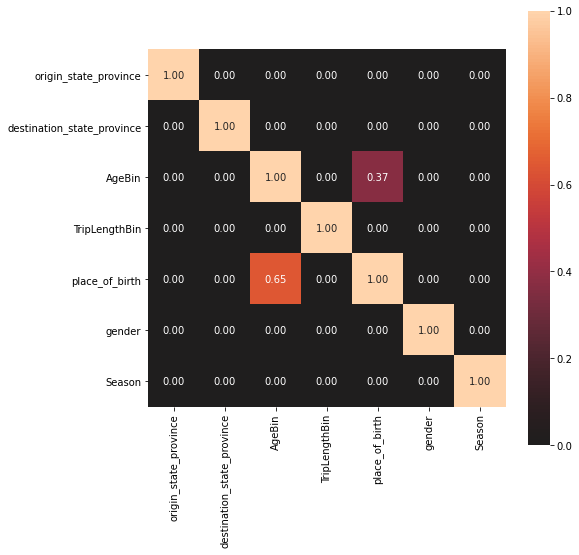

{'corr':                             origin_state_province  destination_state_province  \
 origin_state_province                    1.000000                    0.001197   
 destination_state_province               0.001357                    1.000000   
 AgeBin                                   0.000121                    0.000147   
 TripLengthBin                            0.000202                    0.000282   
 place_of_birth                           0.001563                    0.002136   
 gender                                   0.000036                    0.000033   
 Season                                   0.000066                    0.000118   
 
                               AgeBin  TripLengthBin  place_of_birth    gender  \
 origin_state_province       0.000292       0.000327        0.002153  0.000186   
 destination_state_province  0.000402       0.000517        0.003338  0.000195   
 AgeBin                      1.000000       0.000039        0.369655  0.000026   
 TripL

In [14]:
categorical_list = ['origin_state_province', 'destination_state_province', 
                    'AgeBin', 'TripLengthBin', 'place_of_birth',
                    'gender', 'Season']
df_categorical = data[categorical_list]
# Plot features associations Theil's U
associations(df_categorical, theil_u=True, figsize=(8, 8))

D:\Data_Science_Tools\Anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


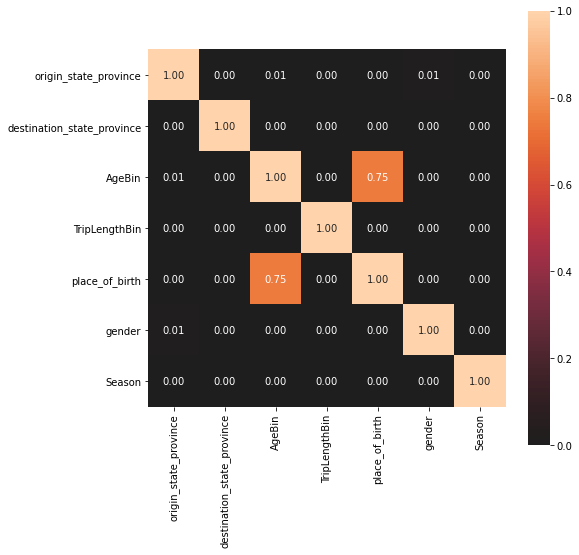

{'corr':                             origin_state_province  destination_state_province  \
 origin_state_province                    1.000000                    0.002318   
 destination_state_province               0.002318                    1.000000   
 AgeBin                                   0.005180                    0.000000   
 TripLengthBin                            0.000000                    0.000000   
 place_of_birth                           0.001573                    0.002142   
 gender                                   0.008154                    0.000000   
 Season                                   0.000000                    0.003440   
 
                               AgeBin  TripLengthBin  place_of_birth    gender  \
 origin_state_province       0.005180       0.000000        0.001573  0.008154   
 destination_state_province  0.000000       0.000000        0.002142  0.000000   
 AgeBin                      1.000000       0.000000        0.748838  0.003346   
 TripL

In [15]:
# Plot features associations Cramer's V
associations(df_categorical, theil_u=False, figsize=(8, 8))

D:\Data_Science_Tools\Anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


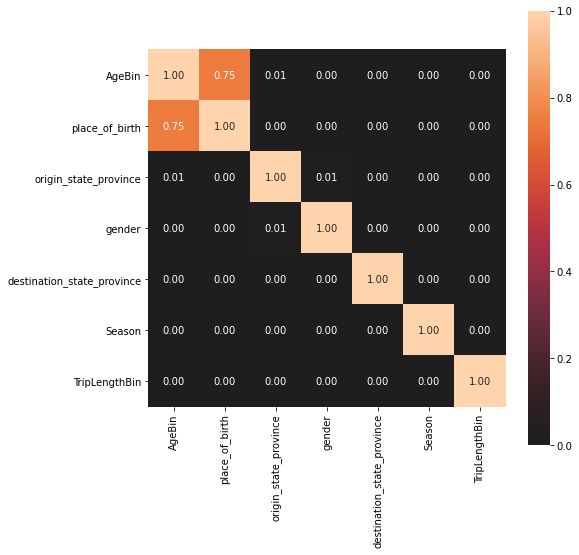

{'corr':                               AgeBin  place_of_birth  origin_state_province  \
 AgeBin                      1.000000        0.748838               0.005180   
 place_of_birth              0.748838        1.000000               0.001573   
 origin_state_province       0.005180        0.001573               1.000000   
 gender                      0.003346        0.001122               0.008154   
 destination_state_province  0.000000        0.002142               0.002318   
 Season                      0.001179        0.000000               0.000000   
 TripLengthBin               0.000000        0.000000               0.000000   
 
                               gender  destination_state_province    Season  \
 AgeBin                      0.003346                    0.000000  0.001179   
 place_of_birth              0.001122                    0.002142  0.000000   
 origin_state_province       0.008154                    0.002318  0.000000   
 gender                      1.000

In [16]:
# Plot features associations: the computed associations will be sorted into groups by similar correlations
associations(df_categorical, clustering=True, figsize=(8, 8))

# Association Rules Generation from Frequent Itemsets

In [17]:
df_encoded = pd.get_dummies(df_categorical)

In [18]:
# Apriori min support
min_support = 0.01
frequent_items = apriori(df_encoded, use_colnames=True, min_support=min_support)
rules = association_rules(frequent_items, metric='lift', min_threshold=1)
rules.sort_values(by='confidence', ascending=False).head(30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
505,"(place_of_birth_BHUTAN, Season_Summer)",(AgeBin_0-9),0.015913,0.265253,0.015913,1.000000,3.769981,0.011692,inf
161,(place_of_birth_AFGHANISTAN),(AgeBin_0-9),0.021900,0.265253,0.021900,1.000000,3.769981,0.016091,inf
499,"(Season_Spring, place_of_birth_BHUTAN)",(AgeBin_0-9),0.015658,0.265253,0.015658,1.000000,3.769981,0.011505,inf
495,"(Season_Autumn, place_of_birth_BHUTAN)",(AgeBin_0-9),0.014863,0.265253,0.014863,1.000000,3.769981,0.010921,inf
489,"(gender_male, place_of_birth_BHUTAN)",(AgeBin_0-9),0.037036,0.265253,0.037036,1.000000,3.769981,0.027212,inf
485,"(gender_female, place_of_birth_BHUTAN)",(AgeBin_0-9),0.024469,0.265253,0.024469,1.000000,3.769981,0.017979,inf
479,"(gender_male, place_of_birth_AFGHANISTAN)",(AgeBin_0-9),0.013249,0.265253,0.013249,1.000000,3.769981,0.009735,inf
511,"(Season_Winter, place_of_birth_BHUTAN)",(AgeBin_0-9),0.015071,0.265253,0.015071,1.000000,3.769981,0.011073,inf
163,(place_of_birth_BHUTAN),(AgeBin_0-9),0.061506,0.265253,0.061506,1.000000,3.769981,0.045191,inf
1464,"(TripLengthBin_25-30, place_of_birth_BURMA, ge...",(AgeBin_0-9),0.010532,0.265253,0.010170,0.965634,3.640421,0.007376,21.379924


In [19]:
rules.to_csv('rules.csv',index=False)

In [20]:
target = 'destination_state_province'
results_destination = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)
results_destination.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
134,(gender_male),(destination_state_province_OH),0.601654,0.020488,0.012407,0.020621,1.006492,0.000080,1.000136
142,(gender_male),(destination_state_province_SC),0.601654,0.020375,0.012318,0.020473,1.004801,0.000059,1.000100
129,(gender_male),(destination_state_province_NM),0.601654,0.020274,0.012258,0.020375,1.004936,0.000060,1.000102
130,(gender_male),(destination_state_province_NV),0.601654,0.019859,0.012211,0.020296,1.021981,0.000263,1.000446
110,(gender_male),(destination_state_province_ID),0.601654,0.020061,0.012140,0.020177,1.005804,0.000070,1.000119
146,(gender_male),(destination_state_province_VA),0.601654,0.019924,0.012080,0.020079,1.007744,0.000093,1.000157
107,(gender_male),(destination_state_province_DC),0.601654,0.019782,0.012045,0.020020,1.012007,0.000143,1.000242
113,(gender_male),(destination_state_province_IL),0.601654,0.019853,0.012039,0.020010,1.007881,0.000094,1.000160
149,(gender_male),(destination_state_province_VT),0.601654,0.019829,0.012027,0.019990,1.008092,0.000097,1.000164
101,(gender_male),(destination_state_province_AZ),0.601654,0.019895,0.011991,0.019931,1.001811,0.000022,1.000037


In [21]:
target = 'origin_state_province'
results_destination = rules[rules['antecedents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)
results_destination.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
34,(origin_state_province_GRO),(gender_male),0.030955,0.601654,0.019260,0.622197,1.034143,0.000636,1.054373
96,(origin_state_province_YUC),(gender_male),0.031400,0.601654,0.019236,0.612623,1.018231,0.000344,1.028315
66,(origin_state_province_Q.),(gender_male),0.031756,0.601654,0.019450,0.612481,1.017996,0.000344,1.027940
55,(origin_state_province_MOR),(gender_male),0.031607,0.601654,0.019313,0.611038,1.015597,0.000297,1.024125
31,(origin_state_province_DGO),(gender_male),0.031174,0.601654,0.019023,0.610202,1.014207,0.000266,1.021928
99,(origin_state_province_ZAC),(gender_male),0.031975,0.601654,0.019426,0.607534,1.009772,0.000188,1.014981
62,(origin_state_province_OAX),(gender_male),0.030996,0.601654,0.018827,0.607389,1.009532,0.000178,1.014607
24,(origin_state_province_COL),(gender_male),0.030883,0.601654,0.018750,0.607109,1.009066,0.000168,1.013882
50,(origin_state_province_MICH),(gender_male),0.031708,0.601654,0.019236,0.606662,1.008323,0.000159,1.012731
64,(origin_state_province_PUE),(gender_male),0.030919,0.601654,0.018750,0.606410,1.007904,0.000147,1.012082


In [22]:
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules[ (rules['antecedent_len'] >= 2)].sort_values(by='confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
479,"(gender_male, place_of_birth_AFGHANISTAN)",(AgeBin_0-9),0.013249,0.265253,0.013249,1.000000,3.769981,0.009735,inf,2
485,"(gender_female, place_of_birth_BHUTAN)",(AgeBin_0-9),0.024469,0.265253,0.024469,1.000000,3.769981,0.017979,inf,2
489,"(gender_male, place_of_birth_BHUTAN)",(AgeBin_0-9),0.037036,0.265253,0.037036,1.000000,3.769981,0.027212,inf,2
495,"(Season_Autumn, place_of_birth_BHUTAN)",(AgeBin_0-9),0.014863,0.265253,0.014863,1.000000,3.769981,0.010921,inf,2
499,"(Season_Spring, place_of_birth_BHUTAN)",(AgeBin_0-9),0.015658,0.265253,0.015658,1.000000,3.769981,0.011505,inf,2
...,...,...,...,...,...,...,...,...,...,...
1744,"(AgeBin_20-39, gender_male)","(Season_Autumn, place_of_birth_IRAQ)",0.205403,0.022470,0.012603,0.061355,2.730565,0.007987,1.041427,2
1804,"(AgeBin_20-39, gender_male)","(place_of_birth_SOMALIA, Season_Summer)",0.205403,0.021764,0.012063,0.058727,2.698369,0.007592,1.039269,2
1794,"(AgeBin_20-39, gender_male)","(Season_Spring, place_of_birth_SOMALIA)",0.205403,0.020613,0.011707,0.056993,2.764971,0.007473,1.038580,2
1818,"(AgeBin_20-39, gender_male)","(place_of_birth_SOMALIA, Season_Winter)",0.205403,0.019948,0.011321,0.055116,2.762956,0.007224,1.037219,2
